<a href="https://colab.research.google.com/github/AsyrofiAnam/Klasifikasi_Kulit_Wajah/blob/main/EfficientNet-B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KLASIFIKASI_KULIT_WAJAH_EfficientNet-B7

#Import Library

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm
import time
from copy import deepcopy
from torch import nn
import random
import pickle

#Install Kaggle & Download Dataset

In [2]:
!pip install -q kaggle

In [3]:
os.environ["KAGGLE_USERNAME"] = "fiin28"
os.environ["KAGGLE_KEY"] = "70a3c7c49b76b5262b742d519723ea8a"

In [4]:
!kaggle datasets download -d fiin28/skintype

Dataset URL: https://www.kaggle.com/datasets/fiin28/skintype
License(s): unknown
 79% 89.0M/112M [00:00<00:00, 929MB/s]
100% 112M/112M [00:00<00:00, 654MB/s] 


In [5]:
!unzip -q skintype.zip

#Membuat Label Index

In [6]:
label_index = {
    "acne": 0,
    "combination": 1,
    "dry": 2,
    "normal": 3,
    "oily": 4
}

index_label = {v: k for k, v in label_index.items()}

#Fungsi create_df

In [7]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        if i in label_index:
            label = os.path.join(base, i)
            for j in os.listdir(label):
                img = os.path.join(label, j)
                dd["images"].append(img)
                dd["labels"].append(label_index[i])
    return pd.DataFrame(dd)

#Mengecek Struktur Dataset

In [8]:
dataset = "/content/Skin_Type"

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"Ada {len(dirnames)} folder dan {len(filenames)} file di direktori: {dirpath}")

walk_through_dir(dataset)

Ada 5 folder dan 0 file di direktori: /content/Skin_Type
Ada 0 folder dan 128 file di direktori: /content/Skin_Type/dry
Ada 0 folder dan 190 file di direktori: /content/Skin_Type/acne
Ada 0 folder dan 175 file di direktori: /content/Skin_Type/normal
Ada 0 folder dan 136 file di direktori: /content/Skin_Type/combination
Ada 0 folder dan 121 file di direktori: /content/Skin_Type/oily


#Membuat DataFrame dari File Gambar

In [9]:
image_dir = Path(dataset)

filepaths = list(image_dir.glob(r'**/*.JPG')) + \
            list(image_dir.glob(r'**/*.jpg')) + \
            list(image_dir.glob(r'**/*.png')) + \
            list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

#Visualisasi Distribusi Label

/tmp/ipython-input-10-994582165.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


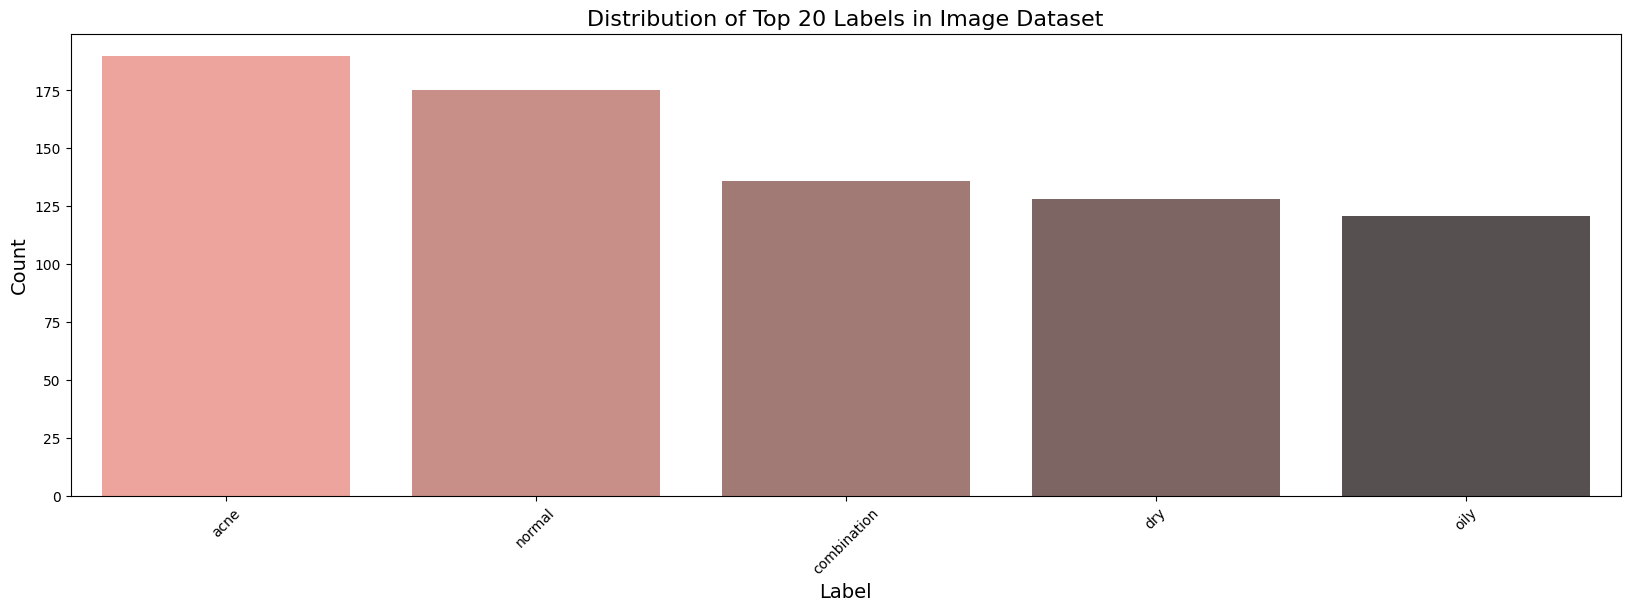

In [10]:
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

#Visualisasi Gambar Dataset

/tmp/ipython-input-11-163713833.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = image_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(2)).reset_index(drop=True)


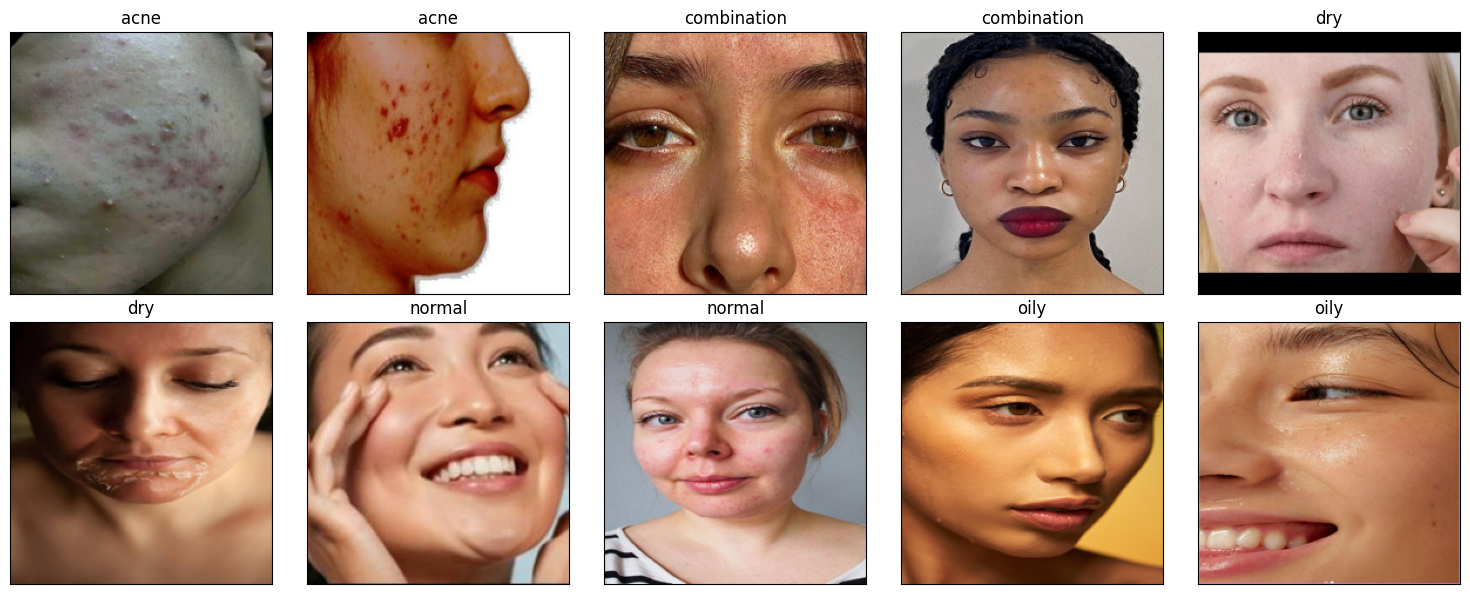

In [11]:
sample_df = image_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(2)).reset_index(drop=True)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = sample_df.Filepath[i]
    label = sample_df.Label[i]

    # Buka dan resize gambar
    img = Image.open(img_path).resize((224, 224))
    ax.imshow(img)
    ax.set_title(label)

plt.tight_layout()
plt.show()

#Split Dataset Train, Val, Test

In [12]:
# Split pertama: 10% untuk test
train_val_df, test_df = train_test_split(
    image_df,
    test_size=0.10,
    shuffle=True,
    random_state=42,
    stratify=image_df['Label']
)

# Split kedua: dari sisa 90%, ambil 1/9 untuk validasi → total ~10%
train_df, val_df = train_test_split(
    train_val_df,
    test_size=1/9,
    shuffle=True,
    random_state=42,
    stratify=train_val_df['Label']
)

# Cek jumlah data
print(f"Jumlah data latih: {len(train_df)}")      # ~80%
print(f"Jumlah data validasi: {len(val_df)}")     # ~10%
print(f"Jumlah data uji: {len(test_df)}")         # ~10%

Jumlah data latih: 600
Jumlah data validasi: 75
Jumlah data uji: 75


#Membuat Struktur Direktori untuk Split

In [13]:
new_base_dir = "./Data_Skin_Type"
train_dir = os.path.join(new_base_dir, "train")
val_dir = os.path.join(new_base_dir, "val")
test_dir = os.path.join(new_base_dir, "test")

def make_dir_for_split(base_dir, df):
    """Buat struktur direktori berdasarkan Label dari DF"""
    for label in df["Label"].unique():
        os.makedirs(os.path.join(base_dir, label), exist_ok=True)

make_dir_for_split(train_dir, train_df)
make_dir_for_split(val_dir, val_df)
make_dir_for_split(test_dir, test_df)

def copy_images(df, base_dir):
    """Salin gambar dari DF ke struktur base_dir"""
    for _, row in df.iterrows():
        src = row["Filepath"]
        label = row["Label"]
        dest_dir = os.path.join(base_dir, label)
        shutil.copy2(src, dest_dir)

print("Menyalin data training...")
copy_images(train_df, train_dir)

print("Menyalin data validation...")
copy_images(val_df, val_dir)

print("Menyalin data testing...")
copy_images(test_df, test_dir)

print("\n✅ Selesai membuat struktur dataset:\n",
      f"Train: {train_dir}\n",
      f"Validation: {val_dir}\n",
      f"Test: {test_dir}")

Menyalin data training...
Menyalin data validation...
Menyalin data testing...

✅ Selesai membuat struktur dataset:
 Train: ./Data_Skin_Type/train
 Validation: ./Data_Skin_Type/val
 Test: ./Data_Skin_Type/test


#Hitung Jumlah Gambar per Kelas

In [14]:
train_class_counts = train_df.groupby('Label').size()
print("Jumlah gambar per kelas pada data latih:")
print(train_class_counts)

val_class_counts = val_df.groupby('Label').size()
print("Jumlah gambar per kelas pada data validasi:")
print(val_class_counts)

test_class_counts = test_df.groupby('Label').size()
print("Jumlah gambar per kelas pada data pengujian:")
print(test_class_counts)

Jumlah gambar per kelas pada data latih:
Label
acne           152
combination    108
dry            102
normal         141
oily            97
dtype: int64
Jumlah gambar per kelas pada data validasi:
Label
acne           19
combination    14
dry            13
normal         17
oily           12
dtype: int64
Jumlah gambar per kelas pada data pengujian:
Label
acne           19
combination    14
dry            13
normal         17
oily           12
dtype: int64


#Membaca DF dari Directory Final

In [15]:
train_df = create_df("/content/Data_Skin_Type/train")
val_df = create_df("/content/Data_Skin_Type/val")
test_df = create_df("/content/Data_Skin_Type/test")

#Membuat Class Dataset PyTorch

In [16]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img_path, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        return img, label

#Definisi Augmentasi dan Pre-processing

In [17]:
train_dir = '/content/Data_Skin_Type/train'
val_dir = '/content/Data_Skin_Type/val'
test_dir = '/content/Data_Skin_Type/test'
target_classes = ["acne", "combination", "dry", "normal", "oily"]

N_AUG = 2

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
        brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_original_count = 0
train_augmented_count = 0
val_count = 0
val_count_after_transform = 0
test_count = 0

for class_name in target_classes:
    class_dir = os.path.join(train_dir, class_name)
    images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    train_original_count += len(images)
    train_augmented_count += len(images) * (N_AUG + 1)

    for img_name in tqdm(images, desc=f"Processing TRAIN - {class_name}"):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        for i in range(N_AUG):
            _ = train_transforms(img)

for class_name in target_classes:
    class_dir = os.path.join(val_dir, class_name)
    images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    val_count += len(images)

    for img_name in tqdm(images, desc=f"Processing VAL - {class_name}"):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        _ = val_test_transforms(img)
        val_count_after_transform += 1

for class_name in target_classes:
    class_dir = os.path.join(test_dir, class_name)
    images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    test_count += len(images)

total_data_akhir = train_augmented_count + val_count_after_transform + test_count

print("\nHASIL AUGMENTASI")
print(f"Kelas Diproses               : {target_classes}")
print(f"Training - Gambar Asli       : {train_original_count}")
print(f"Training - Setelah Aug       : {train_augmented_count}")
print(f"Validation - Jumlah Asli     : {val_count}")
print(f"Validation - Setelah Aug     : {val_count_after_transform}")
print(f"Test - Jumlah Asli           : {test_count}")
print(f"Total data setelah augmentasi: {total_data_akhir}")

Processing VAL - oily: 100%|██████████| 12/12 [00:00<00:00, 77.58it/s]


HASIL AUGMENTASI
Kelas Diproses               : ['acne', 'combination', 'dry', 'normal', 'oily']
Training - Gambar Asli       : 600
Training - Setelah Aug       : 1800
Validation - Jumlah Asli     : 75
Validation - Setelah Aug     : 75
Test - Jumlah Asli           : 75
Total data setelah augmentasi: 1950


#Membuat Dataset dan DataLoader

In [18]:
train_dataset = CloudDS(train_df, transform=train_transforms)
val_dataset = CloudDS(val_df, transform=val_test_transforms)
test_dataset = CloudDS(test_df, transform=val_test_transforms)

train_dl = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=16, shuffle=False)

#Inisialisasi Model dan Optimizer

In [19]:
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

model = efficientnet_b7(weights=EfficientNet_B7_Weights.DEFAULT)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(2560, 5)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 186MB/s]


#Training Model

In [20]:
best_model = deepcopy(model)
best_acc = 0.0
train_loss = []
train_acc = []
val_loss = []
val_acc = []
epochs = 50

def format_time(seconds):
    """Format waktu dari detik menjadi hh:mm:ss"""
    return time.strftime("%Hh %Mm %Ss", time.gmtime(seconds))

for epoch in range(1, epochs + 1):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for data, target in train_dl:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(preds == target.data).item()
        total_samples += data.size(0)

        loss.backward()
        optimizer.step()

    train_epoch_loss = running_loss / total_samples
    train_epoch_acc = running_corrects / total_samples
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)

    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total_samples = 0
    with torch.no_grad():
        for data, target in val_dl:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)

            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * data.size(0)
            val_running_corrects += torch.sum(preds == target.data).item()
            val_total_samples += data.size(0)

    val_epoch_loss = val_running_loss / val_total_samples
    val_epoch_acc = val_running_corrects / val_total_samples
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    if val_epoch_acc > best_acc:
        best_acc = val_epoch_acc
        best_model = deepcopy(model)

    scheduler.step()

    epoch_time = time.time() - epoch_start
    total_batches = len(train_dl)

    bar = "━" * 25
    print(f"Epoch {epoch}/{epochs}")
    print(f"{total_batches}/{total_batches} {bar} {int(epoch_time)}s ", end='')
    print(f"- accuracy: {train_epoch_acc:.4f} - loss: {train_epoch_loss:.4f} ", end='')
    print(f"- val_accuracy: {val_epoch_acc:.4f} - val_loss: {val_epoch_loss:.4f} ", end='')
    print(f"- learning_rate: {optimizer.param_groups[0]['lr']:.4e}")

total_time = time.time() - (train_loss[0] * epochs)
print(f"\nTraining complete in {format_time(total_time)}")
print(f"Best val_acc: {best_acc:.4f}")

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━━━━━━ 32s - accuracy: 0.4400 - loss: 1.4515 - val_accuracy: 0.5467 - val_loss: 1.2562 - learning_rate: 1.0000e-04
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━━━━━━ 30s - accuracy: 0.6433 - loss: 1.0090 - val_accuracy: 0.7200 - val_loss: 0.7677 - learning_rate: 1.0000e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━━━━━━ 32s - accuracy: 0.7617 - loss: 0.6702 - val_accuracy: 0.8000 - val_loss: 0.5629 - learning_rate: 1.0000e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━━━━━━ 31s - accuracy: 0.8333 - loss: 0.4771 - val_accuracy: 0.8400 - val_loss: 0.5202 - learning_rate: 1.0000e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━━━━━━ 31s - accuracy: 0.8467 - loss: 0.4432 - val_accuracy: 0.8133 - val_loss: 0.4940 - learning_rate: 1.0000e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━━━━━━ 31s - accuracy: 0.8867 - loss: 0.3257 - val_accuracy: 0.8533 - val_loss: 0.4786 - learning_rate: 1.0000e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━━━━━━ 32s - accuracy: 0.8700 - loss: 0.3445 - val_accurac

#Evaluasi Model dengan Test Dataset

In [21]:
model.eval()
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_targets = []
all_preds = []
with torch.no_grad():
    for data, targets in test_dl:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        preds = outputs.argmax(1)

        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

test_acc = accuracy_score(all_targets, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9333


#Classification Report

In [22]:
cr = classification_report(all_targets, all_preds,
                           target_names=["acne", "combination", "dry", "normal", "oily"])
print("Classification Report:\n", cr)

Classification Report:
               precision    recall  f1-score   support

        acne       0.90      1.00      0.95        19
 combination       0.92      0.79      0.85        14
         dry       1.00      0.85      0.92        13
      normal       0.89      1.00      0.94        17
        oily       1.00      1.00      1.00        12

    accuracy                           0.93        75
   macro avg       0.94      0.93      0.93        75
weighted avg       0.94      0.93      0.93        75



# Plot Training vs Validation (Loss dan Accuracy)

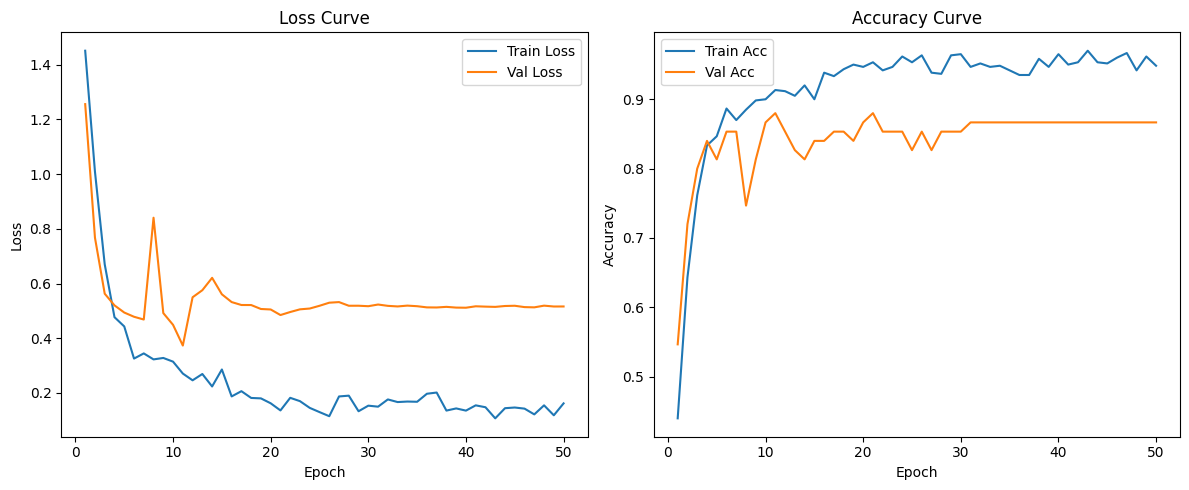

In [23]:
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

#Confusion Matrix

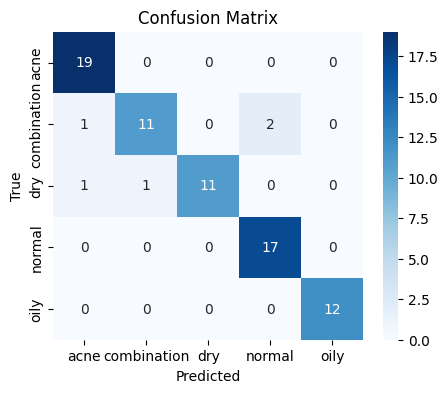

In [24]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["acne", "combination", "dry", "normal", "oily"],
            yticklabels=["acne", "combination", "dry", "normal", "oily"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Visualisasi Prediksi Model

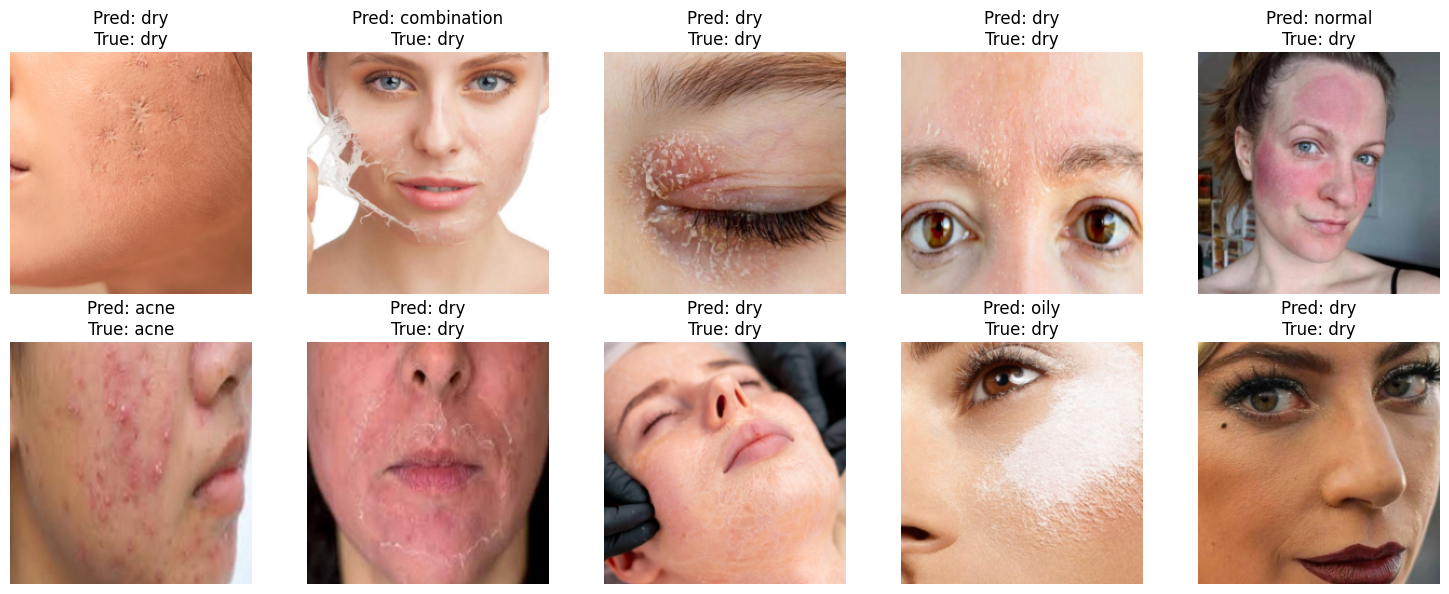

In [25]:
model.eval()

data_iter = iter(val_dl)
images, labels = next(data_iter)

images = images.to(device)
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(1)

images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

num_images = 10
batch_size = images.shape[0]

random_indices = random.sample(range(batch_size), num_images)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_indices):
    img = images[idx].permute(1, 2, 0)

    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clamp(0, 1)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"Pred: {index_label[preds[idx].item()]}\nTrue: {index_label[labels[idx].item()]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

#Simpan Model dan Statistik Training

In [26]:
torch.save(best_model.state_dict(), "best_skin_model.pth")
torch.save(best_model, "best_skin_model_entire.pth")

training_stats = {
    "train_loss": train_loss,
    "val_loss": val_loss,
    "train_acc": train_acc,
    "val_acc": val_acc,
}

with open("training_stats.pkl", "wb") as f:
    pickle.dump(training_stats, f)

with open("label_maps.pkl", "wb") as f:
    pickle.dump({"label_index": label_index, "index_label": index_label}, f)

print("Model dan training statistik berhasil disimpan!")

Model dan training statistik berhasil disimpan!


#Prediksi Sekali dengan Model Final

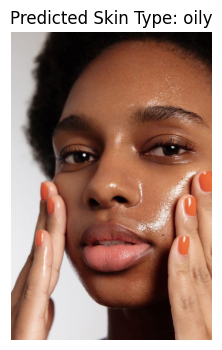

In [27]:
your_image_path = "/content/Data_Skin_Type/test/oily/oily (72).jpg"

single_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open(your_image_path).convert("RGB")
input_tensor = single_transform(img).unsqueeze(0)

input_tensor = input_tensor.to(device)
with torch.no_grad():
    output = model(input_tensor)
    pred = output.argmax(1).item()

predicted_class = index_label[pred]

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f"Predicted Skin Type: {predicted_class}", fontsize=12)
plt.axis("off")
plt.show()